# Vanilla GAN

- Referecnce : https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

## Define Generator & Discriminator
- layers would be mlp
- Activations except last one are nn.LeakyReLU(0.2)
- BachNorm parameter = 0.8
- Dropout p = 0.5

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.block1 = self.make_block(100,256)
        self.block2 = self.make_block(256,512)
        self.block3 = self.make_block(512,1024)
        self.dropout = nn.Dropout()
        self.fc_last = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()

    def make_block(self, in_feat, out_feat):
        #### Implement Here ####
        layers = []
        layers += [nn.Linear(in_feat, out_feat),
                   nn.LeakyReLU(0.2),
                   nn.BatchNorm1d(out_feat)]

        return nn.Sequential(*layers)

    def forward(self, z):
        #### Implement Here ####
        z = self.block1(z)
        z = self.block2(z)
        z = self.block3(z)
        z = self.dropout(z)
        z = self.fc_last(z)
        z = self.tanh(z)
        img = z.view(z.size(0), 1, 28, 28)
        
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.act = nn.LeakyReLU(0.2)
        self.act_last = nn.Sigmoid()
        
    def forward(self, img):
        #### Implement Here ####
        # Hint : Image should be resized before go through network
        x = img.view(img.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        x = self.act_last(x)

        return x

In [5]:
# Initialize generator and discriminator
G = Generator()
D = Discriminator()

In [6]:
from torchsummary import summary
summary(G, device = 'cpu', batch_size = -1, input_size = (100,))
summary(D, device = 'cpu', batch_size = -1, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
         LeakyReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 512]         131,584
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                 [-1, 1024]         525,312
         LeakyReLU-8                 [-1, 1024]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
          Dropout-10                 [-1, 1024]               0
           Linear-11                  [-1, 784]         803,600
             Tanh-12                  [-1, 784]               0
Total params: 1,489,936
Trainable params: 1,489,936
Non-trainable params: 0
---------------------------

## Define loss & Optimizer & model

In [7]:
# Loss function
criterion = torch.nn.BCELoss()

# Optimizer for each network
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0001, betas = (0.5, 0.9999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0001, betas = (0.5, 0.9999))

## Use MNIST Dataset & DataLoader

In [8]:
train_bs = 64

dataset = datasets.MNIST("./mnist", train=True, download=True, 
                         transform=transforms.Compose([transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_bs, shuffle=True, drop_last=True)

torch.Size([64, 1, 28, 28]) tensor([5, 9, 6, 3, 1, 0, 6, 3, 4, 1, 2, 4, 8, 6, 2, 9, 3, 4, 4, 7, 6, 4, 2, 5,
        8, 4, 8, 6, 9, 6, 3, 1, 9, 5, 6, 1, 6, 7, 8, 3, 5, 5, 9, 2, 8, 5, 1, 4,
        7, 1, 3, 9, 0, 2, 8, 1, 3, 0, 8, 1, 2, 3, 7, 3])


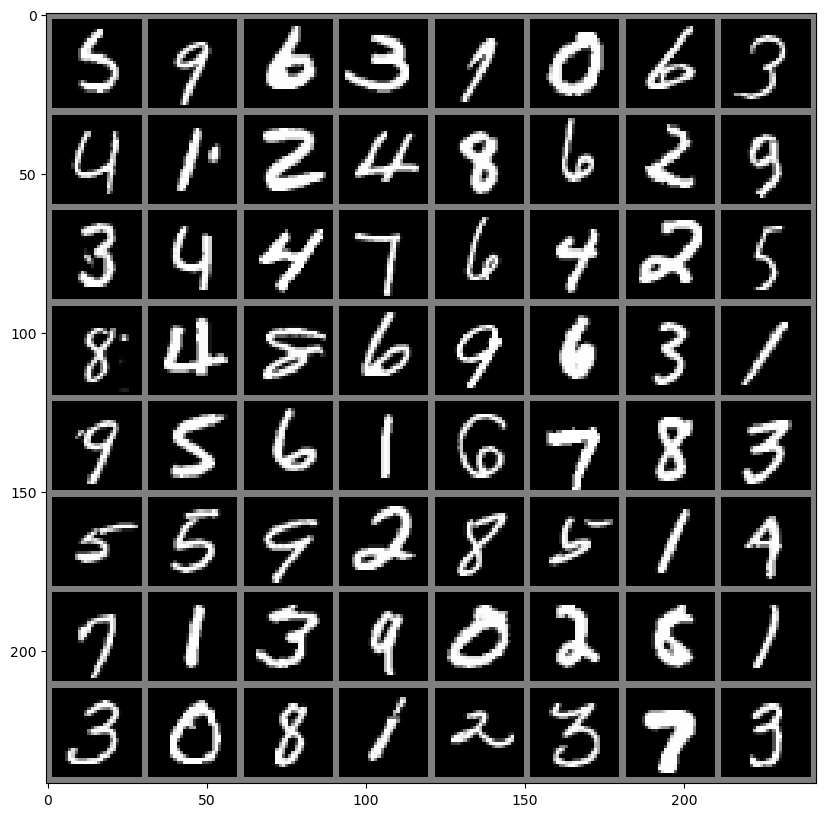

In [9]:
import matplotlib.pyplot as plt
import numpy as np

batch = next(iter(dataloader))
len(batch)
print(batch[0].shape, batch[1])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(batch[0]))

## Start Training

In [10]:
print(device)

cuda:1


In [11]:
G, D = G.to(device), D.to(device)
os.makedirs("./mlpgan", exist_ok=True)
epochs = 200

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):

        # -----------------
        #  Train Generator
        # -----------------
        real_imgs = real_imgs.to(device)

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], 100))).to(device)

        # Generate a batch of images
        gen_imgs = G(z)
        
        # Loss measures generator's ability to fool the discriminator
        ones = torch.ones(gen_imgs.size(0), 1).to(device)
        g_loss = criterion(D(gen_imgs), ones)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        zeros = torch.zeros((gen_imgs.size(0),1)).to(device)
        real_loss = criterion(D(real_imgs), ones)
        fake_loss = criterion(D(gen_imgs.detach()), zeros)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        
        if batches_done % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch+1,epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 2000 == 0:
            save_image(gen_imgs.data, "mlpgan/%06d.png" % batches_done, nrow=8, normalize=True)
            imshow(torchvision.utils.make_grid(gen_imgs.cpu()))